In [1]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [96]:
%matplotlib inline

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
 # TODO is this line still needed?
lmtest = importr('lmtest')
# https://stackoverflow.com/questions/32983365/rpy2-cannot-find-installed-external-r-packages
Hmisc = importr("Hmisc")
pandas2ri.activate()

import statsmodels.api as sm
from sklearn.utils import resample
lowess = sm.nonparametric.lowess

In [3]:
# stat functions
def run_r_corr(df, corr_type='spearman', p_correction='BH'):
    """
    Runs R correlation calculations and p-value corrections on the given dataframe.
    
    :returns: a tuple of (correlations, counts, p_values)
    """
    num_cols = len(df.columns.values)
    r_dataframe = pandas2ri.py2ri(df)
    r_as = r['as.matrix']
    rcorr = r['rcorr'] 
    r_p_adjust = r['p.adjust']
    result = rcorr(r_as(r_dataframe), type=corr_type)
    rho = result[0]
    n = result[1]
    p = result[2]
    
    if p_correction is not None:
        p = r_p_adjust(p, p_correction)
    r_corrs = pandas2ri.ri2py(rho)
    r_p_vals = pandas2ri.ri2py(p)
    r_counts = pandas2ri.ri2py(n)
    r_p_vals = np.reshape(r_p_vals, (num_cols,num_cols))
    return r_corrs, r_counts, r_p_vals

def build_corr_mat(corrs, p_vals, labels, title, alpha):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = [20,12]
    plt.imshow(corrs)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(r_corrs[i, j])
            p = p_vals[i,j]
            if p < alpha / len(labels):
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


In [224]:
# boostrap test
def bootstrap_lowess(df, x_col, y_col, color, label, n_bootstraps=100, n_samples=100):

    x_min = df[x_col].min()
    x_max = df[x_col].max()
    sample_y = np.zeros((n_bootstraps, n_samples))
    sample_x = np.zeros((n_bootstraps, n_samples))


    for i in range(n_bootstraps):
        resampled_df = resample(df, n_samples=n_samples)
        x = resampled_df[x_col]
        y = resampled_df[y_col]

        filtered = lowess(y, x, return_sorted=True, frac=0.66, it=2)
        sample_y[i, :] = filtered[:, 1]
        sample_x[i, :] = filtered[:, 0]

    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 97.5, axis=0), color=color, ls='--')
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 50, axis=0), color=color, label=label)
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 2.5, axis=0), color=color, ls='--')
    plt.legend()

groups = {
    'all': ['family_live_together', 'family_live_separate', 'family_together', 'social', 'friend', 'work', 'task', 'sig_other'],
    'social': ['family_live_separate', 'friend', 'social'],
    'work': ['work'],
    'family_together': ['family_live_together', 'sig_other', 'family_together'],
    'task': ['task']
#         'friend': ['friend'],
#         'work': ['work'],
#         'family_live_together': ['family_live_together'],
#         'sig_other': ['sig_other'],
#         'family_live_separate': ['family_live_separate'],
#         'task': ['task']
}

colors = {
    'all': 'red',
    'social': 'blue',
    'work': 'green',
    'family_together': 'orange',
    'task': 'purple'
}    
    
def plot_all_bootstrap_lowess(features, x_col, y_col, ylim, yticks, xlim, xticks, n_bootstraps=100):
    fig = plt.figure()
    fig.add_subplot(111, frameon=False)
    subplot_num = 321
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    for label, contact_types in groups.items():
        plt.subplot(subplot_num)
        df = features.loc[ag_features['contact_type'].isin(contact_types)]
        bootstrap_lowess(df, x_col, y_col, colors[label], label, n_bootstraps=n_bootstraps, n_samples=100)
        plt.ylim(ylim)
        plt.yticks(yticks)
        plt.xlim(xlim)
        plt.xticks(xticks)
        
        subplot_num += 1

    plt.text(64, -0.1, x_col, ha='center')
    plt.text(0.04, 0.5, y_col, va='center', rotation='vertical')
    plt.suptitle("LOWESS of {} as a function of {}".format(x_col, y_col))


# Demographics feature analysis

## Updated abstract

Estimating the category and quality of interpersonal relationships from ubiquitous phone sensor data has potential applications in studying mental well-being and social support. Prior works utilized the volume of communications to estimate broad relationship categories. In this paper, we contextualize communication events by combining phone logs with demographic and location data to predict social roles as well as relationship qualities such as closeness. We explore the role of user demographics in predicting interpersonal relationships and find age to contribute the most to model performance, an interaction with communication trends across social roles. Our findings not only illustrate the value of utilizing data across different modalities, but also underscore the importance of considering population heterogeneity in phone-based mental health studies.

In [160]:
# load age-based features
#with open("../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df", "rb") as f:
#with open("../data/final_features/top10_all_dedup_nan_train_features.df", "rb") as f:
with open("../data/final_features_jan28/top_5_age_gender_train_features.df", "rb") as f:
    ag_features = pickle.load(f)
    
map_dict = {
    "friend": "social",
    "family_live_separate": "social",
    "family_live_together": "family_together",
    "sig_other": "family_together",
    "work": "work",
    "task": "task"
}

ag_features['contact_type'] = ag_features['contact_type'].map(map_dict)

## Age descriptive statistics

- we see that age is roughly normally distributed, and unsurpisingly there is  no direct relationship between age and social contacts

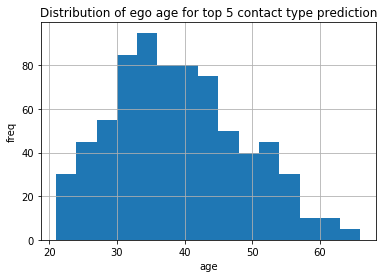

In [6]:
ag_features['ego_age'].hist(bins=15)
plt.ylabel("freq")
plt.xlabel("age")
plt.title("Distribution of ego age for top 5 contact type prediction")
plt.show()

In [7]:
ag_features['ego_age'].describe()

count    735.000000
mean      38.564626
std        9.642145
min       21.000000
25%       31.000000
50%       38.000000
75%       46.000000
max       66.000000
Name: ego_age, dtype: float64

In [8]:
screener_df = pd.read_csv('../CS120/CS120Clinical/CS120Final_Screener.csv', encoding = "ISO-8859-1")
screener_df['pid'] = screener_df['ID']
phq_dict = pd.Series(screener_df['score_PHQ'].values, index=screener_df['pid']).to_dict()
gad_dict = pd.Series(screener_df['score_GAD'].values, index=screener_df['pid']).to_dict()
ag_features['ego_phq'] = ag_features['pid'].map(phq_dict)
ag_features['ego_gad'] = ag_features['pid'].map(gad_dict)

In [10]:
# with open("../data/final_features/top10_age_gender_dedup_nan_test_features.df", "rb") as f:
#     test_ag_features = pickle.load(f)

# test_ag_features.drop_duplicates("pid"['ego_age'].describe()

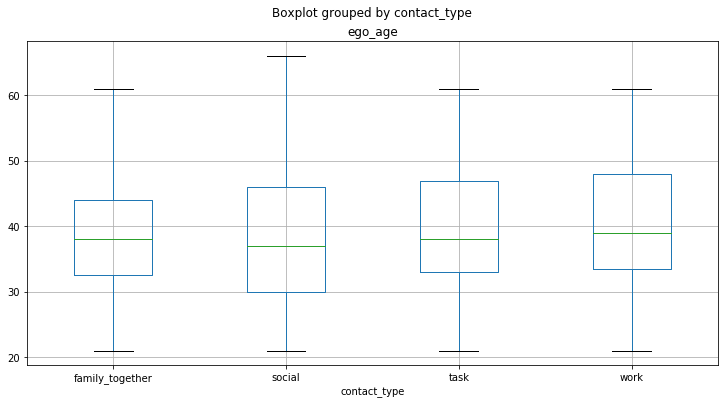

In [43]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_age', by='contact_type')
plt.show()

## Performance increase when including age/gender

- however, we see the largest increase in test performance when including age and gender, with little further improvement when including other demographics or location-based features

- **Note**: 5-fold CV results show the only performance bump with age/gender, though much smaller from over baseline (66% acc to 68.5% acc)

![](../tex/figures/top5_collapsed_f1_test.png)

## Feature importance using SHAP

[SHAP reference](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)

- we see that time of day call and text frequency are the most important features
- overall comunication volume is also important (total_comm_days, total_comms)

![](../tex/figures/age_gender_shap.png)

## Age analysis in the context of communication features

In [162]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))


In [163]:
cols = corr_df.columns.values
age_idx = np.where(cols=='ego_age')

### significant correlations with age (FDR < 0.05), Benjamini-Hochberg corrected

- some of the time of day, day of week communication features are significantly correlated with age

In [226]:
age_corrs = r_corrs[age_idx]
age_p_vals = r_p_vals[age_idx]

age_stats = np.transpose(np.vstack((age_corrs, age_p_vals)))
age_df = pd.DataFrame(age_stats, index=cols, columns=['corr', 'p'])
sig_features = age_df.loc[age_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.str.startswith("ego")]
sig_features = sig_features.loc[~sig_features.index.str.endswith("indicator")]
sig_features = sig_features.loc[~sig_features.index.str.startswith("q")]

sig_features.sort_values(by='corr')
#sig_features.shape

,corr,p
time_of_day_0_sms,-0.159501,0.000035
day_6_sms,-0.144346,0.000207
reg_sms,-0.122905,0.001690
std_in_sms,-0.118806,0.002452
time_of_day_5_sms,-0.116507,0.003031
total_sms_days,-0.112331,0.004363
mean_in_sms,-0.102024,0.010198
med_out_sms,-0.102010,0.010208
std_out_sms,-0.100914,0.011142
max_in_sms,-0.097736,0.014195


### EMC correlations

In [15]:
age_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,-0.021972,0.635000
q2_talk,-0.084653,0.037394
q3_loan,-0.081666,0.045218
q4_closeness,-0.062887,0.133810


### Observations

- as age increases:
    - willingness for communication increases
    - willingness to talk about importance matters decreases
    - willingness to ask for loans decreases
    - duration of call duration increases
    - tendency to call over text increases
    - less communication on Saturday
    - less texts in the evening
    
- argument: people of different age groups communicate with their friends, family differently

## LOWESS

- If we analyze the distribution of temporal features as a function of age across the different contact types, we see some variations in trends 

### Temporal features

### Night (8pm - 12am) texts
- most important temporal feature, according to SHAP analysis
- Though the overall trend is downward (see "all" line in blue), there are large variations in trends across contact types within our population
- overall trend: the older you are, the less frequent texts at night are
- however, only "task" and "social" contacty types correctly track this trend
- **note**: dotted lines are 95% CI, over 1000 bootstraps

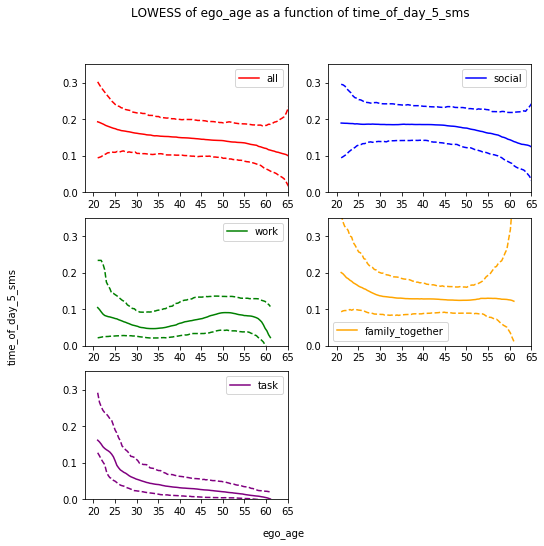

In [222]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_5_sms', (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 5))

### Late morning (8 am - 12 pm) calls

- second-most important temporal communication feature
- less divergence in distribution across the different contact types other than task

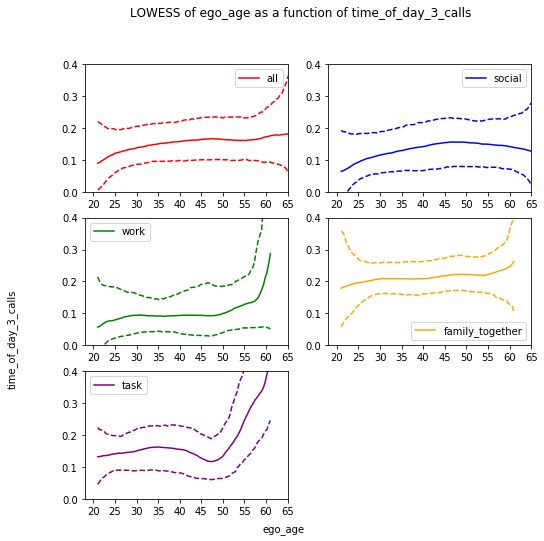

In [242]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_3_calls', (0,0.4), np.arange(0, 0.45, 0.1), (18, 65), np.arange(20, 66, 5), 1000)

### Night (8pm - 12 am) calls


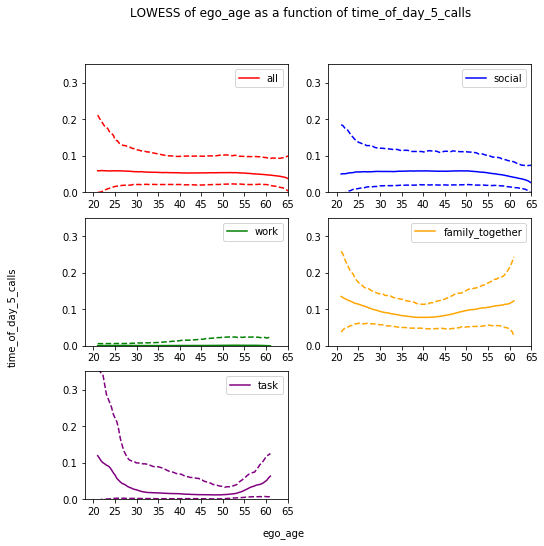

In [240]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_5_calls', (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 5), 1000)

### Regularity features

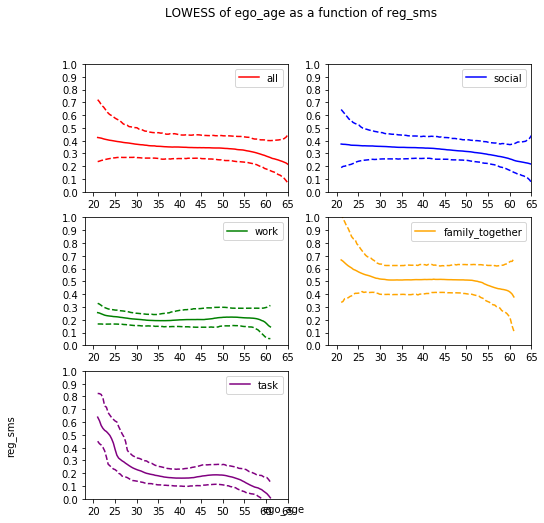

In [234]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'reg_sms', (0,1), np.arange(0, 1.1, .1), (18, 65), np.arange(20, 66, 5), 1000)

### Channel selection features

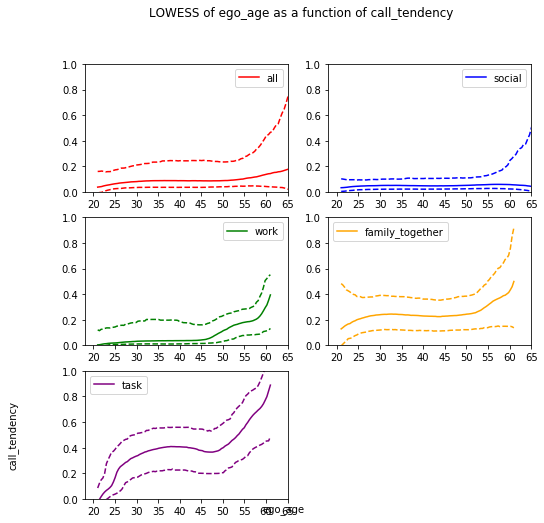

In [243]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'call_tendency', (0,1), np.arange(0, 1.1, .2), (18, 65), np.arange(20, 66, 5), 1000)

## EMC results

- in contrast, we largely see agreement in EMC responses for different contact types, regardless of age
- this is unsurprising as these qualitative measures should not vary too much across age groups

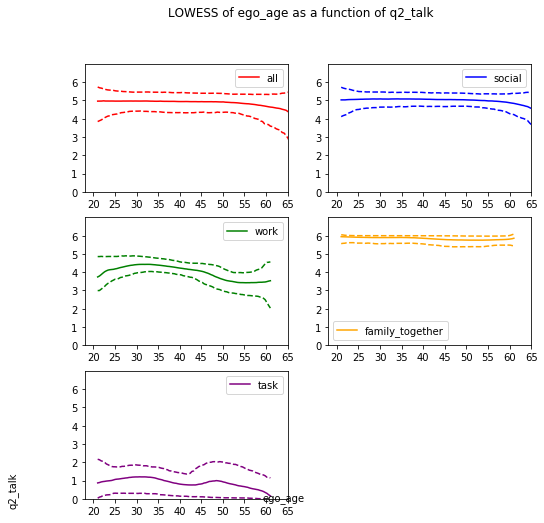

In [296]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'q2_talk', (0,7), np.arange(0, 7, 1), (18, 65), np.arange(20, 66, 5), 1000)

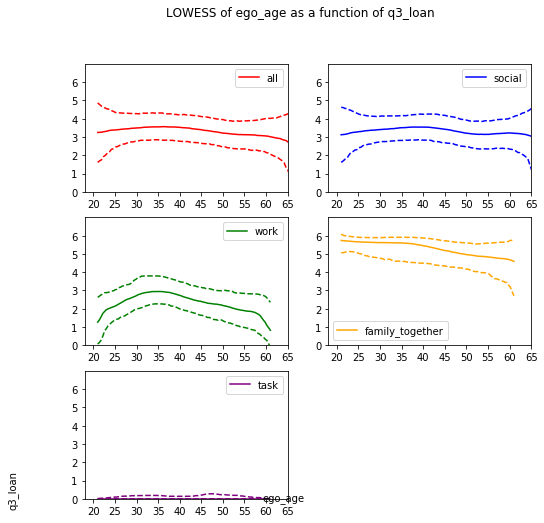

In [297]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'q3_loan', (0,7), np.arange(0, 7, 1), (18, 65), np.arange(20, 66, 5), 1000)

## Gender differences in communication patterns

- we run a paired t-test between male and female participant communication features, across our different contact types
- highlighed are significant p-values (< 0.05)

In [285]:
from scipy.stats import ttest_ind

male_df = ag_features.loc[ag_features['ego_gender_male'] == 1]
female_df = ag_features.loc[ag_features['ego_gender_female'] == 1]

ttest_results = np.zeros((corr_df.columns.values.shape[0], 8))
for col_idx, col in enumerate(corr_df.columns.values):
    for contact_idx, contact in enumerate(ag_features['contact_type'].unique()):
        male_target = male_df.loc[male_df['contact_type'] == contact][col]
        female_target = female_df.loc[female_df['contact_type'] == contact][col]
        t, p = ttest_ind(male_target, female_target)
        ttest_results[col_idx, contact_idx*2] = t
        ttest_results[col_idx, (contact_idx*2)+1] = p

df_cols = []
for contact in ag_features['contact_type'].unique():
    df_cols.append('t_' + contact)
    df_cols.append('p_' + contact)
pd.options.display.float_format = '${:,.3f}'.format
ttest_df = pd.DataFrame(ttest_results, index=corr_df.columns.values, columns=df_cols)



In [286]:
t_sig_df = ttest_df.loc[(ttest_df['p_social'] < 0.05) | (ttest_df['p_family_together'] < 0.05) | (ttest_df['p_task'] < 0.05) | (ttest_df['p_work'] < 0.05)]
t_sig_df = t_sig_df.loc[~t_sig_df.index.str.endswith("indicator")]
t_sig_df = t_sig_df.loc[~t_sig_df.index.str.startswith("ego")]

In [287]:
t_sig_styled = t_sig_df.style.apply(lambda x: ["background: yellow" if np.abs(v) < 0.05 else "" for v in x], axis = 1)
t_sig_styled

,t_social,p_social,t_family_together,p_family_together,t_task,p_task,t_work,p_work
total_comms,0.86197,0.389178,2.62506,0.00949793,-0.354883,0.723882,-0.46066,0.646927
total_calls,0.101694,0.919047,2.48182,0.014098,-0.113245,0.910202,0.195903,0.845435
total_sms,0.860365,0.390061,2.56726,0.0111609,-0.353955,0.724574,-0.499051,0.619809
time_of_day_0_calls,0.923094,0.356469,0.597599,0.550947,-0.259993,0.795731,3.01491,0.00393939
day_2_calls,-1.07478,0.283067,1.03533,0.302065,2.56577,0.0127263,0.492856,0.62415
day_3_calls,-0.966154,0.334503,0.0930895,0.925948,2.06914,0.0427083,0.508839,0.612977
time_of_day_0_sms,3.00018,0.00285288,1.67536,0.0958038,-0.35894,0.72086,2.30981,0.0248245
time_of_day_4_sms,0.659373,0.510004,0.129242,0.897327,0.422808,0.673898,-2.30773,0.0249484
mean_out_call,0.485618,0.627482,2.58897,0.010508,0.914865,0.363807,0.424256,0.673097
std_out_call,0.846559,0.397706,3.03876,0.00277279,0.892991,0.375315,0.530004,0.598323


### Significant features

- note: many of the significant communication features appear to be due to outliers

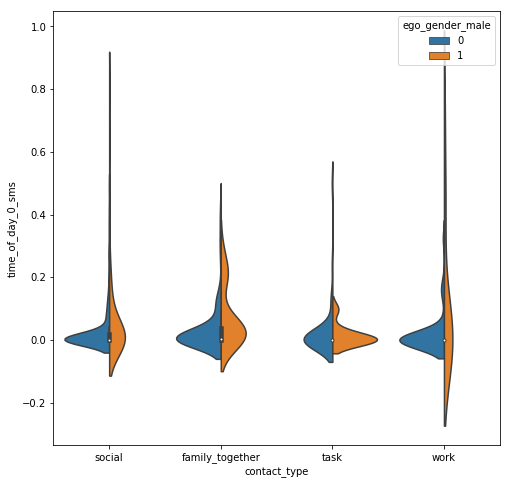

In [298]:
import seaborn as sns
sns.violinplot(x="contact_type", y="time_of_day_0_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

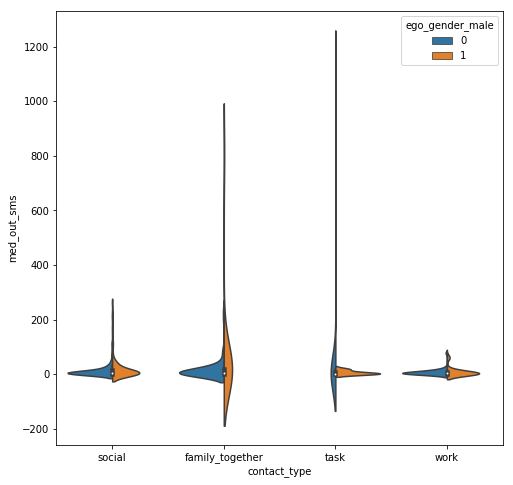

In [299]:
sns.violinplot(x="contact_type", y="med_out_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

### Temporal features

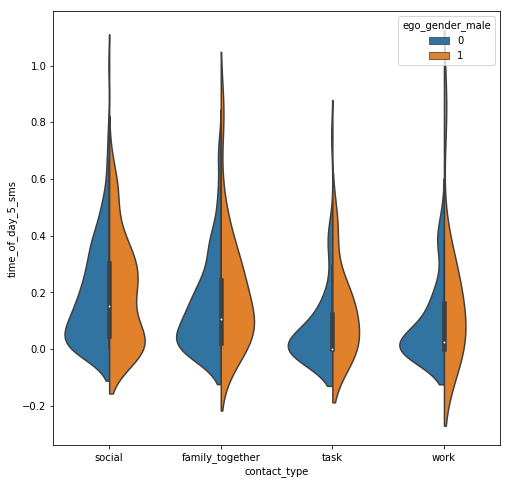

In [300]:
sns.violinplot(x="contact_type", y="time_of_day_5_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

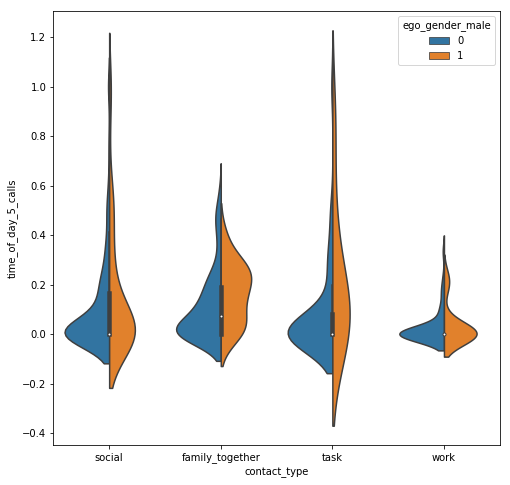

In [301]:
sns.violinplot(x="contact_type", y="time_of_day_5_calls", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

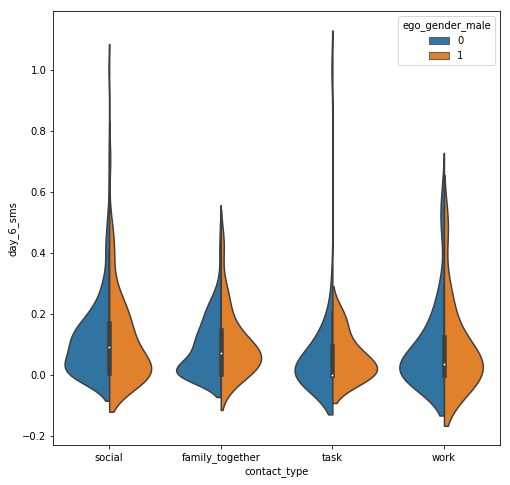

In [302]:
sns.violinplot(x="contact_type", y="day_6_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

### Regularity features

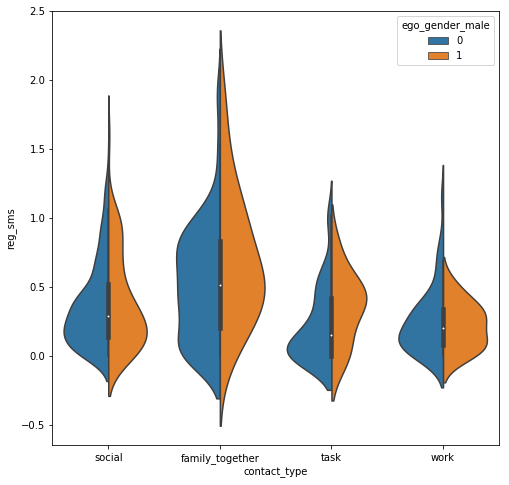

In [303]:
sns.violinplot(x="contact_type", y="reg_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

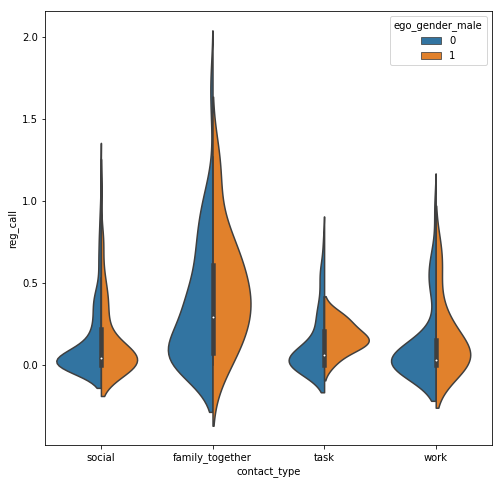

In [304]:
sns.violinplot(x="contact_type", y="reg_call", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

## Additional exploratory work

**note**: these analyses probably won't be used for MobiCom

## PHQ

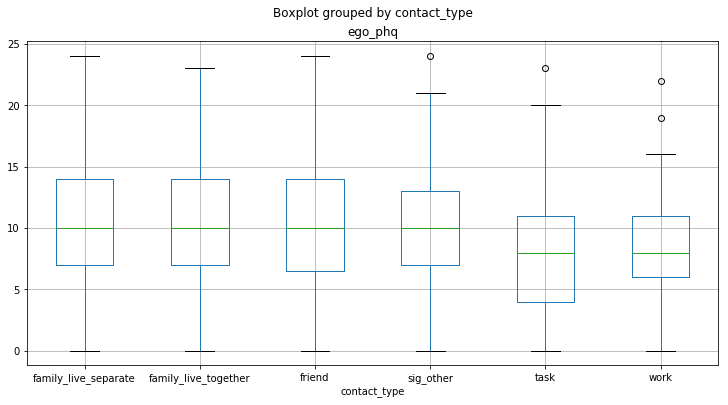

In [29]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_phq', by='contact_type')

In [30]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))


In [31]:
cols = corr_df.columns.values
phq_idx = np.where(cols=='ego_phq')

In [32]:
phq_corrs = r_corrs[phq_idx]
phq_p_vals = r_p_vals[phq_idx]

phq_stats = np.transpose(np.vstack((phq_corrs, phq_p_vals)))
phq_df = pd.DataFrame(phq_stats, index=cols, columns=['corr', 'p'])
phq_df.loc[phq_df['p'] < 0.01].sort_values(by='corr')

,corr,p
ego_age,-0.181440,0.000002
std_in_sms,0.104418,0.008735
total_days,0.105578,0.007975
std_out_sms,0.106773,0.007202
day_6_sms,0.125560,0.001377
ego_gad,0.403165,0.000000


### EMC correlations

In [33]:
phq_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,-0.007536,0.888121
q2_talk,0.001789,0.972392
q3_loan,-0.045503,0.296546
q4_closeness,-0.001303,0.977015


## GAD

In [ ]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_gad', by='contact_type')

In [ ]:
cols = corr_df.columns.values
gad_idx = np.where(cols=='ego_gad')

In [ ]:
gad_corrs = r_corrs[gad_idx]
gad_p_vals = r_p_vals[gad_idx]

gad_stats = np.transpose(np.vstack((gad_corrs, gad_p_vals)))
gad_df = pd.DataFrame(gad_stats, index=cols, columns=['corr', 'p'])
gad_df.loc[gad_df['p'] < 0.01].sort_values(by='corr')

In [ ]:
gad_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "reg_comm", it=0)

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "avg_out_duration", it=0)

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "q2_talk", it=0)